# A2: Bias in data

This notebook includes an analysis on possible bias in the Wikipedia Talk corpus. I focused on the Toxicity and Aggression datasets in order to answer the following questions:

* Does the gender of a worker affect the toxicity score they assign to comments?

* Is the age of the worker a factor when identifying aggressive comments?

---

# Step 1: Performing Two Exploratory Data Analysis

Importing packages for analysis

In [1]:
import urllib
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import numpy as np

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Downloading Toxicity and Agression datasets

Downloading Toxicity and Aggression files from [Figshare site](https://figshare.com/projects/Wikipedia_Talk/16731)

In [5]:
!wget https://ndownloader.figshare.com/files/7394539 -O toxicity_annotations.tsv
!wget https://ndownloader.figshare.com/files/7394542 -O toxicity_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640581 -O toxicity_worker_demographics.tsv

!wget https://ndownloader.figshare.com/files/7394506 -O aggression_annotations.tsv
!wget https://ndownloader.figshare.com/files/7038038 -O aggression_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640644 -O aggression_worker_demographics.tsv

--2020-10-21 19:50:34--  https://ndownloader.figshare.com/files/7394539
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.250.140.125, 54.76.76.248, 34.240.85.170, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.250.140.125|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/7394539/toxicity_annotations.tsv [following]
--2020-10-21 19:50:35--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/7394539/toxicity_annotations.tsv
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.112.11
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.112.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36177321 (35M) [binary/octet-stream]
Saving to: ‘toxicity_annotations.tsv’

toxicity_annotation 100%[===================>]  34.50M  9.18MB/s    in 5.0s    

2020-10-21 19:50:41 (6.93 MB/s) - ‘toxicity_ann

## Loading datasets

Loading data into Jupyter Notebook

In [6]:
toxicity_annotations = pd.read_csv('toxicity_annotations.tsv', delimiter='\t')
toxicity_annotated_comments = pd.read_csv('toxicity_annotated_comments.tsv', delimiter='\t')
toxicity_worker_demographics = pd.read_csv('toxicity_worker_demographics.tsv', delimiter='\t')

aggression_annotations = pd.read_csv('aggression_annotations.tsv', delimiter='\t')
aggression_annotated_comments = pd.read_csv('aggression_annotated_comments.tsv', delimiter='\t')
aggression_worker_demographics = pd.read_csv('aggression_worker_demographics.tsv', delimiter='\t')

Preview of the first 5 rows of each tables

In [7]:
toxicity_annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [8]:
toxicity_annotated_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [9]:
toxicity_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors
1,1617,female,0,45-60,bachelors
2,1394,female,0,NaN,bachelors
3,311,male,0,30-45,bachelors
4,1980,male,0,45-60,masters


In [10]:
aggression_annotations.head()

,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


In [11]:
aggression_annotated_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [12]:
aggression_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education
0,833,female,0,45-60,bachelors
1,1072,male,0,30-45,bachelors
2,872,male,0,18-30,hs
3,2116,male,0,30-45,professional
4,453,male,0,30-45,hs


## Creating joined datasets

Creating two joined dataset with all the tables for each for of hostile speech.

Toxicity dataset:

In [13]:
df_toxicity = joined_annotations = pd.merge(toxicity_annotated_comments, toxicity_annotations, on="rev_id")
df_toxicity = df_toxicity.merge(toxicity_worker_demographics, on='worker_id')

In [14]:
df_toxicity.head()

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,723,0,0.0,female,0,30-45,bachelors
1,37346.0,`If they are ``indisputable`` then why does th...,2002,True,article,random,train,723,0,0.0,female,0,30-45,bachelors
2,227181.0,"NEWLINE_TOKENNEWLINE_TOKENWell, Ayn Rand certa...",2002,True,article,random,train,723,0,0.0,female,0,30-45,bachelors
3,2810755.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2004,True,user,random,train,723,0,0.0,female,0,30-45,bachelors
4,7270696.0,NEWLINE_TOKENNEWLINE_TOKEN==Useful info==NEWLI...,2004,True,article,random,train,723,0,0.0,female,0,30-45,bachelors


Aggression dataset:

In [15]:
df_aggression = joined_annotations = pd.merge(aggression_annotated_comments, aggression_annotations, on="rev_id")
df_aggression = df_aggression.merge(aggression_worker_demographics, on='worker_id')

In [16]:
df_aggression.head()

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train,1362,1.0,-1.0,male,0,18-30,masters
1,3202092,NEWLINE_TOKENNEWLINE_TOKENHi. I haven't used o...,2004,True,user,random,train,1362,0.0,0.0,male,0,18-30,masters
2,4745553,NEWLINE_TOKENJust look it up. Its obvious.,2004,True,user,random,train,1362,0.0,0.0,male,0,18-30,masters
3,4855563,NEWLINE_TOKENNEWLINE_TOKENI'm going to gather ...,2004,True,article,random,test,1362,0.0,0.0,male,0,18-30,masters
4,8350378,`NEWLINE_TOKENNEWLINE_TOKEN§ I got in touch wi...,2004,True,article,random,train,1362,0.0,0.0,male,0,18-30,masters


## Analysis #1: Does the gender of a worker affect the toxicity score they assign to comments?

Adding the number of annotations each worker did, the mean toxicity score they put, and the percentage of comments they identified as toxic to the workers' table.

In [17]:
mean_toxicity_score = df_toxicity.groupby('worker_id')['toxicity_score'].mean().reset_index(name='mean_toxicity_score')
count_annotations_toxicity = df_toxicity.groupby('worker_id')['rev_id'].nunique().reset_index(name='count_annotations')
count_toxic = df_toxicity[df_toxicity['toxicity'] == 1].groupby('worker_id')['rev_id'].nunique().reset_index(name='count_toxic')

toxicity_worker_demographics = toxicity_worker_demographics.merge(mean_toxicity_score, on='worker_id')
toxicity_worker_demographics = toxicity_worker_demographics.merge(count_annotations_toxicity, on='worker_id')
toxicity_worker_demographics = toxicity_worker_demographics.merge(count_toxic, on='worker_id')
toxicity_worker_demographics['percent_toxic'] = toxicity_worker_demographics['count_toxic']/toxicity_worker_demographics['count_annotations']

**Are the workers distributed equally between gender?**

Getting the number of workers by gender

In [18]:
toxicity_worker_demographics.groupby('gender').worker_id.count()

gender
female    1259
male      2318
other        1
Name: worker_id, dtype: int64

The workers are not fairly distributed by gender. Not only are there almost double male-identified workers compared to female-identified, but it also concerns that there is only one marked as 'other'. While this third category could include workers that choose not to identify themselves (the demographics survey was optional), it also groups everyone that does not identify with a binary gender. Transgender people comprise an estimated 0.6% of the general US population ([Flores, Herman, Gates, & Brown, June 2016](https://williamsinstitute.law.ucla.edu/publications/trans-adults-united-states/)), so their lack of representation in the sample means that comments that they would perceive as toxic, due to their past experiences and hardships, could be disregarded by the workers in the sample.  
While I will be focusing the rest of this analysis mostly on male/female genders due to a lack of samples on the 'other' group, I wanted to point out this first potential source of bias found.

**Were the annotations distributed equally between gender?**

Getting how many annotations were marked by each gender

In [19]:
toxicity_worker_demographics.groupby('gender').count_annotations.sum()

gender
female    457307
male      889141
other        358
Name: count_annotations, dtype: int64

The annotations made by male-identified workers almost double the annotations made by female-identified workers. If there is a difference on how workers assign a score based on gender (later analyzed), it could be a source of bias.

**Is there any difference on the mean percentage of comments identified as toxic by gender?**

Calculating the mean percentage of comments that were marked as toxic by workers in each gender.

In [20]:
toxicity_worker_demographics.groupby('gender').percent_toxic.mean()

gender
female    0.162548
male      0.144262
other     0.164804
Name: percent_toxic, dtype: float64

There is a slight difference in how many comments are marked as toxic by each worker, depending on gender. Male-identified workers are more unlikely to identify a comment as toxic. As mentioned before, this could potentially be a source of bias.

**Is there any difference on the mean toxicity score by gender?**

Already having the mean toxicity score that each worker assigned in the workers' demographics table, I want to calculate the mean of this score by gender.

In [21]:
toxicity_worker_demographics.groupby('gender').mean_toxicity_score.mean()

gender
female    0.176501
male      0.228066
other     0.553073
Name: mean_toxicity_score, dtype: float64

There is a noticeable difference between female and male that is going to be explored later in the analysis. As far as the 'other' group, due to only having one worker in the group, we cannot make any assumptions.

**Plotting the findings:**

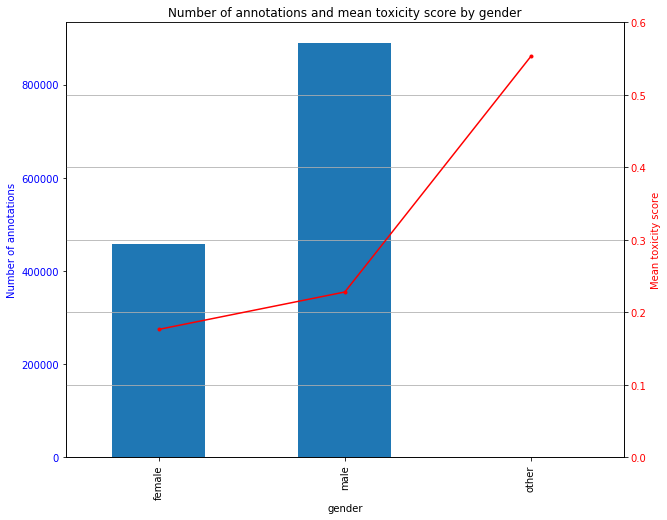

In [38]:
fig, ax1 = plt.subplots(figsize=(10,8))
ax1.set_xlabel('Gender')
ax1.set_ylabel('Number of annotations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
toxicity_worker_demographics.groupby('gender').count_annotations.sum().plot.bar(ax=ax1)

ax2 = ax1.twinx()
ax2.set_xlabel('Gender')
ax2.set_ylabel('Mean toxicity score', color='red')
ax2.set_ylim(bottom=0, top=0.6)
ax2.tick_params(axis='y', labelcolor='red')
toxicity_worker_demographics.groupby('gender').mean_toxicity_score.mean().plot(ax=ax2, color='red', marker=".")

plt.title('Number of annotations and mean toxicity score by gender')

plt.savefig('mean_toxicity_score_by_gender.png')

plt.grid()
plt.show()

There seems to be a bit of a difference in mean toxicity score between female and male identified workers.

**What percentage of annotations were marked for each score?**

Male workers:

In [23]:
dist_male = df_toxicity[df_toxicity['gender'] == 'male'].groupby('toxicity_score').rev_id.count()
dist_male/dist_male.sum()

toxicity_score
-2.0    0.024586
-1.0    0.115300
 0.0    0.483219
 1.0    0.362492
 2.0    0.014403
Name: rev_id, dtype: float64

Female workers:

In [24]:
dist_female = df_toxicity[df_toxicity['gender'] == 'female'].groupby('toxicity_score').rev_id.count()
dist_female/dist_female.sum()

toxicity_score
-2.0    0.030778
-1.0    0.126316
 0.0    0.490653
 1.0    0.337869
 2.0    0.014385
Name: rev_id, dtype: float64

Comments annotated by female-identified workers seem to lean a bit towards the lower scores.

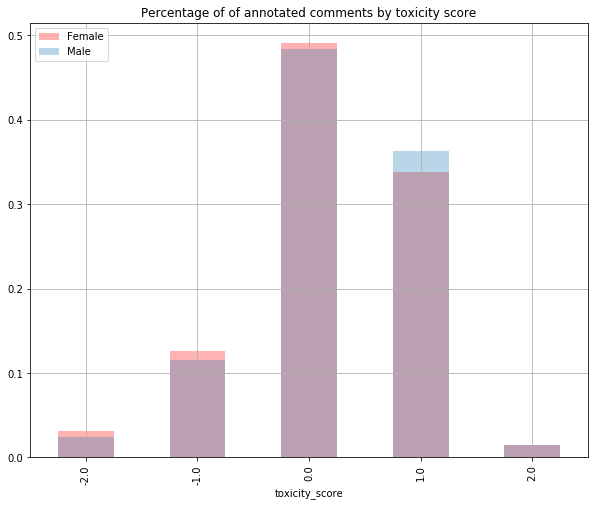

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
(dist_female/dist_female.sum()).plot.bar(alpha=0.3, color='red', label='Female')
(dist_male/dist_male.sum()).plot.bar(alpha=0.3, label='Male')

plt.legend(loc = 'upper left')
plt.title('Percentage of of annotated comments by toxicity score')

plt.savefig('percent_comments_toxicity_score_gender.png')

plt.grid()
plt.show()

While I can visually see a difference in mean toxicity score, I want to see if gender plays a role in the mean score each worker assigns.
 
To do this, I'm going to work under the Null Hypothesis that gender does not make a difference in mean toxicity score and perform a T-Test.

In [26]:
scores_male = toxicity_worker_demographics[toxicity_worker_demographics['gender'] == 'male']['mean_toxicity_score']
scores_female = toxicity_worker_demographics[toxicity_worker_demographics['gender'] == 'female']['mean_toxicity_score']

In [27]:
stat, p = ttest_ind(scores_male, scores_female)
print('Statistics: ', stat)
print('P-Value: ', p)

Statistics:  4.699480400052319
P-Value:  2.706546932187377e-06


The obtained P-Value is lower than the significance level of 0.05, so **I have evidence to reject the Null Hypothesis, which means that female-identified workers on average tend to give lower scores than male-identified workers.**

### Conclusion for Analysis #1: Does the gender of a worker affect the toxicity score they assign to comments?

From the analysis, I found that the unfair worker representation by gender can be a source of bias for models using the 'toxicity' dataset for training.

The absence of non-binary workers (we cannot know if the worker in 'others' chose not to identify themself or identify as non-binary) furthers the problem of underrepresented communities. Female or male-identified workers do not have the same experiences and sensitivity to identify toxic comments as non-binary people. This could result in models failing to recognize toxic comments that affect these underrepresented communities because no one during the annotation phase could acknowledge this type of toxicity.

Analyzing the different toxicity scores assigned by female and male-identified workers shows that male-identified workers give a higher toxicity score than female-identified workers. This, added to the fact that annotations made by male workers almost double the annotations made by female, could be a source of bias for models using this dataset for training. Because they will be learning from a dataset annotated by a majority of males, the models will later assign scores skewed towards 'Healthy' and 'Very healthy'.

## Analysis #2: Is the age of the worker a factor when identifying aggressive comments?

Adding the number of annotations each worker did, the mean aggression score they put and the percentage of comments they identified as aggressive to the workers table.

In [28]:
mean_aggression_score = df_aggression.groupby('worker_id')['aggression_score'].mean().reset_index(name='mean_aggression_score')
count_annotations_aggression = df_aggression.groupby('worker_id')['rev_id'].nunique().reset_index(name='count_annotations')
count_aggression = df_aggression[df_aggression['aggression'] == 1].groupby('worker_id')['rev_id'].nunique().reset_index(name='count_aggression')

aggression_worker_demographics = aggression_worker_demographics.merge(mean_aggression_score, on='worker_id')
aggression_worker_demographics = aggression_worker_demographics.merge(count_annotations_aggression, on='worker_id')
aggression_worker_demographics = aggression_worker_demographics.merge(count_aggression, on='worker_id')
aggression_worker_demographics['percent_aggression'] = aggression_worker_demographics['count_aggression']/aggression_worker_demographics['count_annotations']

**How is the workers population divided between age groups?**

Number of workers in each age group

In [30]:
aggression_worker_demographics.groupby('age_group').worker_id.count()

age_group
18-30       1024
30-45        826
45-60        218
Over 60       20
Under 18      37
Name: worker_id, dtype: int64

Number of comments marked by each age group

In [31]:
df_aggression.groupby('age_group').rev_id.count()

age_group
18-30       391192
30-45       357584
45-60        77313
Over 60       7841
Under 18      9577
Name: rev_id, dtype: int64

Percentage of workers in each age group

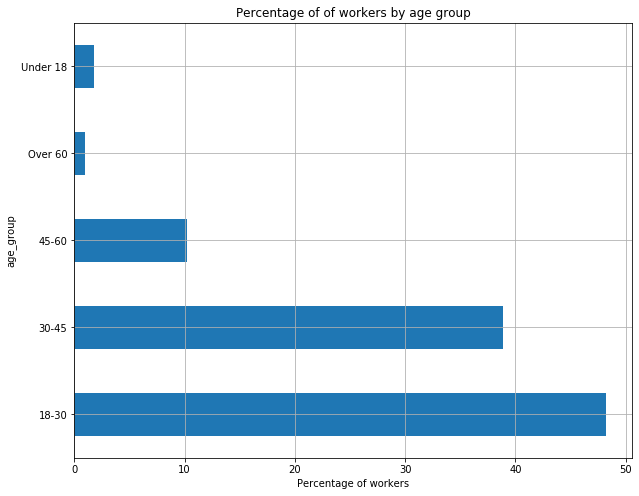

In [40]:
aggression_age = aggression_worker_demographics.groupby('age_group').worker_id.count()

fig, ax = plt.subplots(figsize=(10,8))
(100*aggression_age/aggression_age.sum()).plot.barh()

plt.title('Percentage of of workers by age group')

ax.set_xlabel('Percentage of workers')

plt.savefig('percent_workers_agegroup_aggression.png')

plt.grid()
plt.show()

We can see that the sample of workers is not fairly distributed within age groups.

For example, we know that, as of 2015, the percentage of the population of 65 and over was 14.9% ([United States Census Bureau](https://www.census.gov/newsroom/facts-for-features/2017/cb17-ff08.html)), so we can assume that the current population of more than 60 years old should be significantly larger, as we are taking into account a larger portion of the population (over 60 instead of 65). There is also evidence that the older population's size is growing year by year (it's supposed to double in size by 2060, according to the same article). It's also expected, due to the online nature of the work, that not many older people would be doing this job.

The underrepresentation of the 'Under 18' group is also expected, as there is probably an age requirement to be a worker in Crowdflower and similar platforms.

This means that if there is a difference in how workers in each age group assign an aggression score, the models using this dataset for training could be biased.

**Do workers in different age groups assign different aggression scores?**

Plot the distribution of worker's mean aggression score by age group.

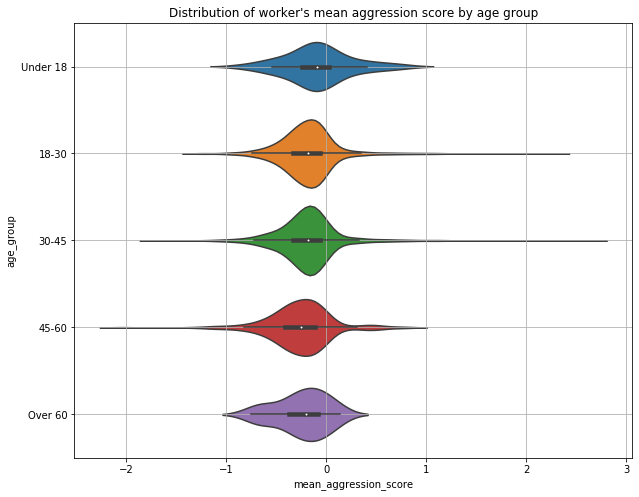

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Distribution of worker's mean aggression score by age group")
sns.violinplot( x='mean_aggression_score', y='age_group', data=aggression_worker_demographics, ax=ax, order=['Under 18', '18-30', '30-45', '45-60', 'Over 60'])

plt.savefig('worker_aggression_score_agregroup.png')

plt.grid()
plt.show()

Worker's mean aggression score by age group.

In [33]:
aggression_worker_demographics.groupby('age_group').mean_aggression_score.mean()

age_group
18-30      -0.175894
30-45      -0.185027
45-60      -0.268210
Over 60    -0.249769
Under 18   -0.085089
Name: mean_aggression_score, dtype: float64

While not extreme, the mean aggression score assigned by older workers (>45) is lower than the rest of the age groups. It seems like the younger the age group the higher the mean agression score gets.

**What percentage of the annotations made by age group were marked as 'aggressive'?**

In [37]:
df_aggression.groupby('age_group').aggression.sum()/df_aggression.groupby('age_group').rev_id.count()

age_group
18-30       0.167593
30-45       0.190369
45-60       0.235937
Over 60     0.236577
Under 18    0.130730
dtype: float64

We can see that a higher percentage of the annotations made by older workers (>45) are marked as 'aggressive' when compared to younger workers.

### Conclusion for Analysis #2: Do workers in different age behave different when marking a comment as 'aggressive'?

The inaccurate representation of age groups of workers in the Aggression dataset is a source of bias that anyone training their models on this dataset should be aware of.

There are a couple of issues that combined contribute to the bias. First, the distribution of workers among all age groups is quite far from the entire population. There is clear over-representation of the population between 18 and 45 years old and a severe lack of workers in the 'Under 18' and 'Over 60' groups. While expected due to the nature of the work mentioned earlier in the analysis, this misrepresentation of the population can be problematic if age is a factor when marking comments as aggressive.

Which brings us to the second finding: there is a difference in mean aggression score, and a higher percentage of comments annotated by older workers are marked as aggressive. Combined with the population's inaccurate representation, it means that models trained with this dataset will be skewed towards a more friendly score, as the training data lacks more records with older workers.

# Step 2: Further implications

### Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?  

I believe that applications like "Toxicity Timeline" and "Hot Topics" would probably perform well from the demo application.  

* "Toxicity Timeline" is an application that aims to find hidden patterns behind toxic behavior, like when is the most toxic time of day or if toxic comments are more likely once a toxic comment appeared in a post. I think that the gender bias found in the toxicity dataset should not impact this application, as the goal is to find patterns and not so much the most precise identification of toxic comments. Even if plenty of comments' toxicity is missed, the functionality could still make sense with the data available.   


* "Hot Topics" is an application that assigns a predicted toxicity score to an article based on the average toxicity of specific categories. While I think that the model could miss certain toxic behavior due to the gender bias in the dataset, I thought the application was worth mentioning because it makes a point of predicting the toxicity based on the same category of past articles. As we learned from [Mixed Messages? The Limits of Automated Social Media Content Analysis (Duarte, N., Llanso, E., & Loup, A. (2018))](https://cdt.org/files/2017/12/FAT-conference-draft-2018.pdf), NLP tools tend to perform best when trained in a similar domain. 


### Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

I think that applications like "Comment Blur Filter" or "Behave!", where the user inputs the desired threshold for toxicity, could perform poorly due to the found bias in the training data based on workers' gender. The level of toxicity assigned was different depending on the gender, so the overrepresentation of male workers will skew the toxicity score. This will result in differences when setting up a threshold. Females are more likely to find a comment to be toxic and could be offended by the comments left after applying a threshold, based mostly on annotations made by male workers.


### What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

The application called "Authorship Feedback" gives users real-time feedback about whether their comment might be considered toxic or in violation of community guidelines. It aims to reduce abuse and harassment from conversations. This application is working under the assumption that the comment author didn't know their comment was toxic and would likely change it when warned by the tool.  

I don't think this assumption is correct most of the time. Users who intend to post a toxic message will still do it no matter the feedback. Besides, knowing that their message could be marked as toxic (and possibly deleted), showing them the "toxicity score" gives them the necessary tool to learn how to trick the model. The author could learn how to reword their message to obtain a better score. For example, on a much different scale, you wouldn't explain to a user exactly why you mark a credit card transaction as fraudulent, as you could be telling the fraudster how to change their methods to trick the fraud prevention model.

That being said, I don't think the consequences are severe enough to recommend not to use the API. I would probably recommend that they don't show the score until they try to submit the comment so that the application could actually store the score of the intended messages and potentially identify toxic users.